<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Joint reactions](02.02-joint-reactions.ipynb) | [Contents](Index.ipynb) | [Analyses](03.00-experts-novices.ipynb) >

# Simple ergonomics indicator

- box-chest distance
- box inclination
- hip-floor distance

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
# from pyosim import Conf
from pyomeca import Markers3d, Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
project_path = Path("/media/romain/E/Projet_ExpertsNovices/opensim/")

In [4]:
def correct_path(x):
    return Path(
        x.replace("home/laboratoire/mnt/E", "/media/romain/E")
        #         .replace("E:", "/media/romain/E")
        .replace("1_inverse_kinematic", "0_markers")
        .replace(".mot", ".trc")
        .replace("wu_expertsnovicesD_", "")
        .replace("wu_expertsnovicesG_", "")
    )


def parse_conditions(d):
    return d.merge(
        pd.read_csv(project_path / "_conf.csv")[["participant", "group"]].rename(
            columns={"group": "expert"}
        ),
        on="participant",
    ).assign(
        fatigue=lambda x: x["filename"].str[0].astype(int) - 1,
        height=lambda x: x["filename"].str[2].astype("category"),
        mass=lambda x: x["filename"].str[3:5].astype(int),
        filename=lambda x: x["participant"] + "_" + x["filename"],
        participant=lambda x: x["participant"].astype("category"),
        n_trial=lambda x: x["filename"].str.split("_").str[-1],
    )

In [5]:
box_markers = [
    "front_r_X",
    "front_r_Y",
    "front_r_Z",
    "mid_r_X",
    "mid_r_Y",
    "mid_r_Z",
    "back_r_X",
    "back_r_Y",
    "back_r_Z",
    "back_l_X",
    "back_l_Y",
    "back_l_Z",
    "front_l_X",
    "front_l_Y",
    "front_l_Z",
]


def box_thorax_distance(x):
    box = pd.concat(
        [x[box_markers].filter(like=i).mean(axis=1).rename(i) for i in ["X", "Y"]],
        axis=1,
    )
    thorax = x.filter(like="XIPH").rename(columns=lambda x: x.replace("XIPH_", ""))
    return (
        np.sqrt(((box - thorax) ** 2).sum(axis=1))
        .replace(0, np.nan)
        .interpolate()
        .rename("box_thorax")
        .to_frame()
    )

In [6]:
hip_markers = [
    "ASISl_X",
    "ASISl_Y",
    "ASISl_Z",
    "ASISr_X",
    "ASISr_Y",
    "ASISr_Z",
    "PSISl_X",
    "PSISl_Y",
    "PSISl_Z",
    "PSISr_X",
    "PSISr_Y",
    "PSISr_Z",
]


def hip_normalized_displacement(x):
    hip = x[hip_markers].filter(like="Z").mean(axis=1)
    #     ref = hip.loc[0]

    p = x.loc[0, "participant"]
    kwargs = dict(
        header=3,
        first_row=6,
        first_column=1,
        time_column=1,
        delimiter="\t",
        last_column_to_remove=1,
    )
    try:
        try:
            ref = (
                Markers3d.from_csv(
                    f"{project_path}/{p}/0_markers/irssten_{p}d0.trc", **kwargs
                )
                .to_dataframe()[hip_markers]
                .filter(like="Z")
                .mean(axis=1)
                .mean()
            )
        except IndexError:
            kwargs["last_column_to_remove"] = 0
            ref = (
                Markers3d.from_csv(
                    f"{project_path}/{p}/0_markers/irssten_{p}d0.trc", **kwargs
                )
                .to_dataframe()[hip_markers]
                .filter(like="Z")
                .mean(axis=1)
                .mean()
            )
    except FileNotFoundError:
        try:
            ref = (
                Markers3d.from_csv(
                    f"{project_path}/{p}/0_markers/irssten_{p}g0.trc", **kwargs
                )
                .to_dataframe()[hip_markers]
                .filter(like="Z")
                .mean(axis=1)
                .mean()
            )
        except IndexError:
            kwargs["last_column_to_remove"] = 0
            ref = (
                Markers3d.from_csv(
                    f"{project_path}/{p}/0_markers/irssten_{p}g0.trc", **kwargs
                )
                .to_dataframe()[hip_markers]
                .filter(like="Z")
                .mean(axis=1)
                .mean()
            )

    return (
        (hip - ref)
        .replace(0, np.nan)
        .interpolate()
        .rename("hip_displacement")
        .to_frame()
    )

In [7]:
# x = Markers3d.from_csv(
#     filename,
#     header=3,
#     first_row=6,
#     first_column=1,
#     time_column=1,
#     delimiter="\t",
#     last_column_to_remove=1,
# )
# idx = np.logical_and(
#     x.get_time_frames < ifile["offset"], x.get_time_frames > ifile["onset"]
# )
# x = (
#     x[..., idx]
#     .to_dataframe()
#     .assign(
#         filename=filename.stem,
#         participant=filename.parent.parent.stem,
#         time=lambda x: x.index / 100,
#     )
# )

In [8]:
# clav_markers = [
#     "CLAV_SC_X",
#     "CLAV_SC_Y",
#     "CLAV_SC_Z",
#     "CLAV_ACm_X",
#     "CLAV_ACm_Y",
#     "CLAV_ACm_Z",
# ]
# clav_height = x[clav_markers].filter(like="Z").mean(axis=1)
# box_height = x[box_markers].filter(like="Z").mean(axis=1)

## Box-chest distance

In [10]:
markers = []
f = []
onsets = pd.read_csv(project_path / "onsets.csv")
for _, ifile in onsets.iterrows():
    filename = correct_path(ifile["filepathK"])
    if filename in f:
        continue
    else:
        f.append(filename)
    try:
        e = Markers3d.from_csv(
            filename,
            header=3,
            first_row=6,
            first_column=1,
            time_column=1,
            delimiter="\t",
            last_column_to_remove=1,
        )
    except FileNotFoundError:
        print(f"{filename} not found")
        continue

    idx = np.logical_and(
        e.get_time_frames < ifile["offset"], e.get_time_frames > ifile["onset"]
    )
    markers.append(
        e[..., idx]
        .time_normalization()
        .to_dataframe()
        .assign(filename=filename.stem, participant=filename.parent.parent.stem)
        .pipe(box_thorax_distance)
        #         .pipe(hip_normalized_displacement)
        .assign(filename=filename.stem, participant=filename.parent.parent.stem)
    )
markers = (
    pd.concat(markers)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .pipe(parse_conditions)
    .query('fatigue == 0 & height == "r"')
    .drop("fatigue", axis=1)
)

markers.sample(5)

/media/romain/E/Projet_ExpertsNovices/opensim/gaud/0_markers/1_r12_1.trc  not found
/media/romain/E/Projet_ExpertsNovices/opensim/gaud/0_markers/1_r12_2.trc  not found


,index,box_thorax,filename,participant,expert,height,mass,n_trial
46957,0.93,332.694791,sylg_1_r08_6,sylg,0,r,8,6
928,0.19,NaN,antc_1_r08_5,antc,0,r,8,5
3464,0.30,231.801332,beng_1_r08_6,beng,0,r,8,6
13413,0.81,366.877906,didl_1_r08_3,didl,0,r,8,3
42813,0.90,458.864611,samc_1_r08_6,samc,0,r,8,6


In [12]:
height = (
    pd.read_csv(project_path / "_conf.csv")
    .query("process == 1")[["participant", "height"]]
    .rename(columns={"height": "p_height"})
)

In [13]:
box_thorax = (
    markers.merge(height, on="participant", how="left").eval(
        "box_thorax = box_thorax / (p_height * 10)"
    )
    #     .eval("box_thorax = hip_displacement / (p_height * 10)")
    .drop("p_height", axis=1)
    #     .drop("hip_displacement", axis=1)
    .dropna()
)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [14]:
box_thorax.drop_duplicates(["filename", "participant"]).groupby(
    ["expert", "mass"]
).size()

expert  mass
0       8       72
        12      79
1       8       50
        12      39
dtype: int64

In [15]:
balanced_trials = random_balanced_design(
    box_thorax, ["expert", "mass"], random_state=RANDOM_SEED, participant=True
)
_filename, _participant = (
    balanced_trials["filename"].to_list(),
    balanced_trials["participant"].to_list(),
)

In [16]:
box_thorax = box_thorax.query("filename == @_filename & participant == @_participant")
box_thorax.drop_duplicates(["filename", "participant"]).groupby(
    ["expert", "mass"]
).size()

expert  mass
0       8       39
        12      39
1       8       39
        12      39
dtype: int64

### Stats

In [17]:
id_vars = ["filename", "participant", "expert", "height", "mass", "n_trial", "index"]
y = (
    box_thorax.assign(
        participant=lambda x: x["participant"].astype("category").cat.codes
    )
    .set_index(id_vars)
    .unstack()
)
y = y.fillna(y.mean())

y.head()

box_thorax            \
index                                                     0.00      0.01   
filename     participant expert height mass n_trial                        
antc_1_r08_1 0           0      r      8    1         0.172939  0.171920   
antc_1_r08_4 0           0      r      8    4         0.178855  0.174063   
antc_1_r08_5 0           0      r      8    5         0.178855  0.174063   
antc_1_r08_6 0           0      r      8    6         0.285169  0.283806   
antc_1_r12_1 0           0      r      12   1         0.178855  0.174063   

                                                                         \
index                                                    0.02      0.03   
filename     participant expert height mass n_trial                       
antc_1_r08_1 0           0      r      8    1        0.170901  0.169882   
antc_1_r08_4 0           0      r      8    4        0.169872  0.165694   
antc_1_r08_5 0           0      r      8    5        0.169872  0.165694   
antc_1_r08_6 0           0      r      8    6        0.281817  0.279593   
antc_1_r12_1 0           0      r      12   1        0.169872  0.165694   

                                                                         \
index                                                    0.04      0.05   
filename     participant expert height mass n_trial                       
antc_1_r08_1 0           0      r      8    1        0.168864  0.167845   
antc_1_r08_4 0           0      r      8    4        0.161360  0.157029   
antc_1_r08_5 0           0      r      8    5        0.161360  0.157029   
antc_1_r08_6 0           0      r      8    6        0.276841  0.273583   
antc_1_r12_1 0           0      r      12   1        0.161360  0.157029   

                                                                         \
index                                                    0.06      0.07   
filename     participant expert height mass n_trial                       
antc_1_r08_1 0           0      r      8    1        0.166826  0.165807   
antc_1_r08_4 0           0      r      8    4        0.152654  0.148313   
antc_1_r08_5 0           0      r      8    5        0.152654  0.148313   
antc_1_r08_6 0           0      r      8    6        0.269951  0.265913   
antc_1_r12_1 0           0      r      12   1        0.152654  0.148313   

                                                                         ...  \
index                                                    0.08      0.09  ...   
filename     participant expert height mass n_trial                      ...   
antc_1_r08_1 0           0      r      8    1        0.164789  0.163770  ...   
antc_1_r08_4 0           0      r      8    4        0.144410  0.140638  ...   
antc_1_r08_5 0           0      r      8    5        0.144410  0.140638  ...   
antc_1_r08_6 0           0      r      8    6        0.261597  0.257011  ...   
antc_1_r12_1 0           0      r      12   1        0.144410  0.140638  ...   

                                                                         \
index                                                    0.91      0.92   
filename     participant expert height mass n_trial                       
antc_1_r08_1 0           0      r      8    1        0.217043  0.225738   
antc_1_r08_4 0           0      r      8    4        0.272147  0.279357   
antc_1_r08_5 0           0      r      8    5        0.250183  0.253158   
antc_1_r08_6 0           0      r      8    6        0.101184  0.103976   
antc_1_r12_1 0           0      r      12   1        0.273174  0.275023   

                                                                         \
index                                                    0.93      0.94   
filename     participant expert height mass n_trial                       
antc_1_r08_1 0           0      r      8    1        0.235511  0.245357   
antc_1_r08_4 0           0      r      8    4        0.286672  0.293904   
antc_1_r08_5 0         

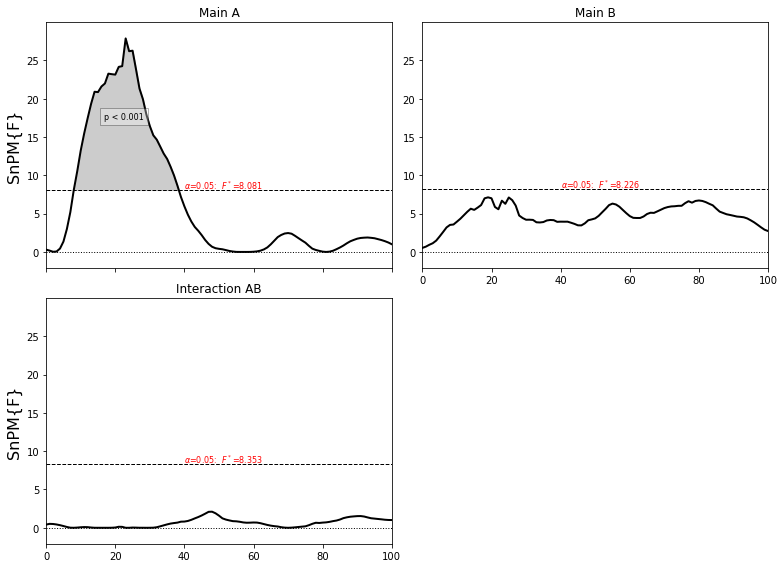

In [18]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(),
    A=y.index.get_level_values("expert"),
    B=y.index.get_level_values("mass"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [19]:
effect = {
    "Main A": "main sex",
    "Main B": "main mass",
    "Interaction AB": "interaction sex-mass",
}

clusters = get_spm_cluster(spmi, labels=effect, mult=1 / y.shape[1])
clusters

,effect,p,start,end
0,main sex,0,0.079109,0.379952


In [20]:
effect = {"main sex": "expert", "main mass": "mass", "interaction sex-mass": "expert"}
clusters = describe_clusters(
    clusters, box_thorax.rename(columns=dict(box_thorax="value")), effect
)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
0,main sex,0.0,0.08,0.38,0 - 1,0.02,0.67,medium


In [21]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [22]:
base = alt.Chart(box_thorax).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(
    alt.Y(
        "mean(box_thorax)",
        title="box-thorax distance (% height)",
        axis=alt.Axis(format="%"),
    )
)
sigma = base.mark_errorband(extent="ci").encode(alt.Y("box_thorax", title=None))
men_scale = alt.Scale(scheme="set1")

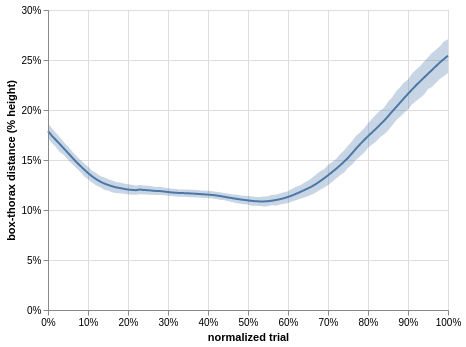

In [23]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

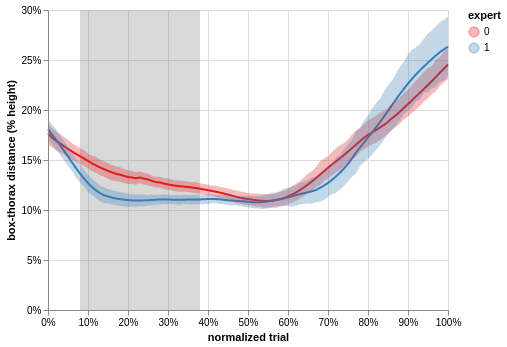

In [24]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("expert:N", scale=men_scale)
)

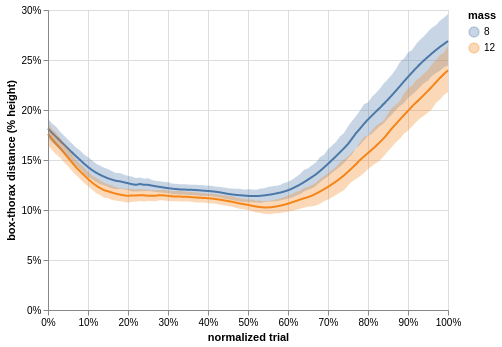

In [25]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

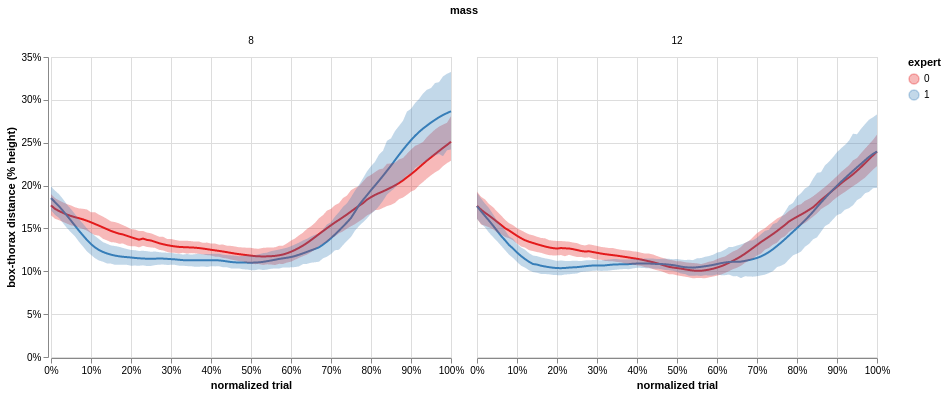

In [26]:
(mu + sigma).encode(alt.Color("expert:N", scale=men_scale)).facet(column="mass")

<!--NAVIGATION-->
< [Joint reactions](02.02-joint-reactions.ipynb) | [Contents](Index.ipynb) | [Analyses](03.00-experts-novices.ipynb) >